***Note :*** Always Check if input and output tokens llm require are under 'max_token' you decided
- I limited the token that created the problem that made create_post function to not generate post
- and give an empty result
- It took me 15 minutes to debug 

***Note :*** Consistent naming
- I named class varibles differently , it caused me problem i debuggiung
- just name them consistently if if they are different ,classes ,function,etc 
- unles their content is different maintain consistency

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator

In [3]:
load_dotenv()
model = ChatGoogleGenerativeAI(
    model='gemini-2.0-flash-lite',
    max_tokens=1000
)

In [4]:
class PostSchema(BaseModel):
    evaluation: Literal["approved", "remake"] = Field(..., description="Final evaluation result of Linkldn post.")
    feedback: str = Field(..., description="Constructive feedback about post strengths and weaknesses")

In [5]:
generator_model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash'
)

evaluator_model = model.with_structured_output(PostSchema)

optimizer_model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash'
)

In [6]:
class PostState(TypedDict):
    topic : str
    post : str
    evaluation : Literal['approved','remake']
    feedback : str
    iterations : int
    max_iter :int
    post_history :Annotated[list[str],operator.add]
    feedback_history : Annotated[list[str],operator.add]

In [ ]:
# the given propmpt is only for testing iterations ,the Original prompt is
#  messages = [
#         SystemMessage(content="You are a witty, relatable, and ambitious engineering student on LinkedIn."),
#         HumanMessage(content=f"""
# Write a short, original, and engaging LinkedIn post on the topic: "{state['topic']}".

# Rules:
# - Keep it concise (2–4 sentences).
# - Tone: professional yet authentic, like a student sharing thoughts or experiences.
# - Add a touch of wit, light humor, or relatability (but not cringe).
# - Should show curiosity, learning, or personal growth.
# - No hashtags, emojis, or forced motivation.
# """)
#     ]
def post_creator(state:PostState):
    messages = [
    SystemMessage(content="You are a witty, relatable, and ambitious engineering student on LinkedIn."),
    HumanMessage(content=f"""
Creat a linkldn post using following context
""")
]
    response = generator_model.invoke(messages).content
    return {'post':response,'post_history':[response]}


In [9]:
def post_evaluator(state: PostState):
    # Stop if we've already hit max iterations
    if state.get("iterations", 1) >= state.get("max_iter", 3):
        return {
            "evaluation": "approved",
            "feedback": "Accepted after reaching max iterations.",
            "feedback_history": state.get("feedback_history", []),
        }

    messages = [
        SystemMessage(content="""
You are a constructive but firm LinkedIn post critic. 
Goal: help refine the post in no more than 3 iterations.
Be forgiving if the post is decent, but reject clearly weak drafts.
"""),
        HumanMessage(content=f"""
Evaluate the following LinkedIn post:

Post: "{state['post']}"

Criteria:
1. Originality – Should feel personal and authentic.  
2. Clarity – Should be easy to follow and well-structured.  
3. Professionalism – Should balance professional + relatable tone.  
4. Engagement – Should spark curiosity or conversation.  
5. Format – Concise (2–4 sentences), no hashtags/emojis.  

Reject only if:
- It’s cliché motivational filler ("Never give up…").  
- It’s overloaded with jargon or salesy.  
- It has hashtags/emojis.  
- It feels fake, generic, or incoherent.  

### Respond ONLY in this JSON-like format:
- evaluation: "approved" or "remake"  
- feedback:  
    - If approved → 1–2 sentences on strengths, plus at most one suggestion.  
    - If remake → 1–2 clear points on what needs fixing (no long lists).
""")
    ]

    response = evaluator_model.invoke(messages)

    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "feedback_history": [response.feedback]
    }


In [10]:
def post_optimizer(state:PostState):
    messages = [
    SystemMessage(content="You improve LinkedIn posts to make them clearer, more engaging, and professional while keeping an authentic student voice."),
    HumanMessage(content=f"""
Improve the LinkedIn post based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Post:
{state['post']}

Re-write it as a short, engaging LinkedIn post (2–4 sentences).  
Rules:
- Professional but authentic (like a student sharing thoughts or experiences).  
- No hashtags, emojis, or Q&A style.  
- Avoid motivational clichés and corporate buzzwords.  
""")
]
    response = optimizer_model.invoke(messages).content
    iterations = state['iterations']+1
    return {'post':response,'iterations':iterations,'post_history':[response]}

In [11]:
def post_validator(state:PostState):
    if state['evaluation']=='approved' or state['iterations']>=state['max_iter']:
        return 'approved'
    else:
        return 'remake'

In [12]:
graph = StateGraph(PostState)

graph.add_node('Create_Post',post_creator)
graph.add_node('Evaluate_Post',post_evaluator)
graph.add_node('Optimize_Post',post_optimizer)

graph.add_edge(START,'Create_Post')
graph.add_edge('Create_Post','Evaluate_Post')
graph.add_conditional_edges('Evaluate_Post',post_validator,{'approved':END,'remake':'Optimize_Post'})
graph.add_edge('Optimize_Post','Evaluate_Post')

workflow = graph.compile()

In [13]:
initial_state = {
    "topic": """I Have built a agentic ai to mail pepople on my behalf
    - i learned langchain and langgraph to do it
    - it took me month to make
    - and i like agentic ai""",
    "iterations": 1,
    "max_iter": 3
}

result = workflow.invoke(initial_state)
result


{'topic': 'I Have built a agentic ai to mail pepople on my behalf\n    - i learned langchain and langgraph to do it\n    - it took me month to make\n    - and i like agentic ai',
 'post': "After a month of dedicated work, I'm excited to share that I've built an agentic AI to handle email outreach on my behalf. This project was a deep dive into frameworks like LangChain and LangGraph, pushing my understanding of autonomous systems. Seeing it in action confirms my growing interest in the capabilities of agentic AI.",
 'evaluation': 'approved',
 'feedback': "The post is clear, professional, and highlights a specific accomplishment. Consider adding a brief note about the project's impact or your next steps to further boost engagement.",
 'iterations': 2,
 'max_iter': 3,
 'post_history': ['Alright, here are a few options for a LinkedIn post, playing with different angles of the witty, relatable, and ambitious engineering student persona. Choose the one that best fits your current mood or si

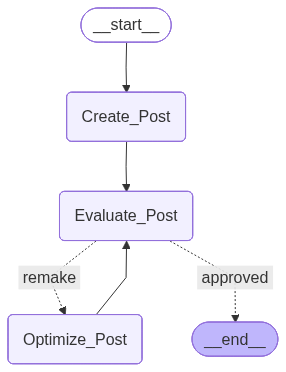

In [14]:
workflow

In [15]:
from IPython.display import Image
print(workflow.get_graph().draw_ascii())

              +-----------+             
              | __start__ |             
              +-----------+             
                     *                  
                     *                  
                     *                  
              +-------------+           
              | Create_Post |           
              +-------------+           
                     *                  
                     *                  
                     *                  
            +---------------+           
            | Evaluate_Post |           
            +---------------+           
              ***         ...           
             *               .          
           **                 ..        
+---------------+           +---------+ 
| Optimize_Post |           | __end__ | 
+---------------+           +---------+ 
